In [1]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import OneCycleLR

import lightning as L
from lightning import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor
from lightning.pytorch.loggers import WandbLogger

import wandb
from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

In [2]:
L.seed_everything(125)

Global seed set to 125


125

## Load Noisy Data

In [3]:
df = pd.read_parquet("./data.parquet")
df

,x,y
0,0.0000,20.239212
1,0.1001,19.173246
2,0.2002,19.736660
3,0.3003,19.289800
4,0.4004,19.614940
...,...,...
995,99.5996,13.279275
996,99.6997,14.038843
997,99.7998,13.098245
998,99.8999,13.125170


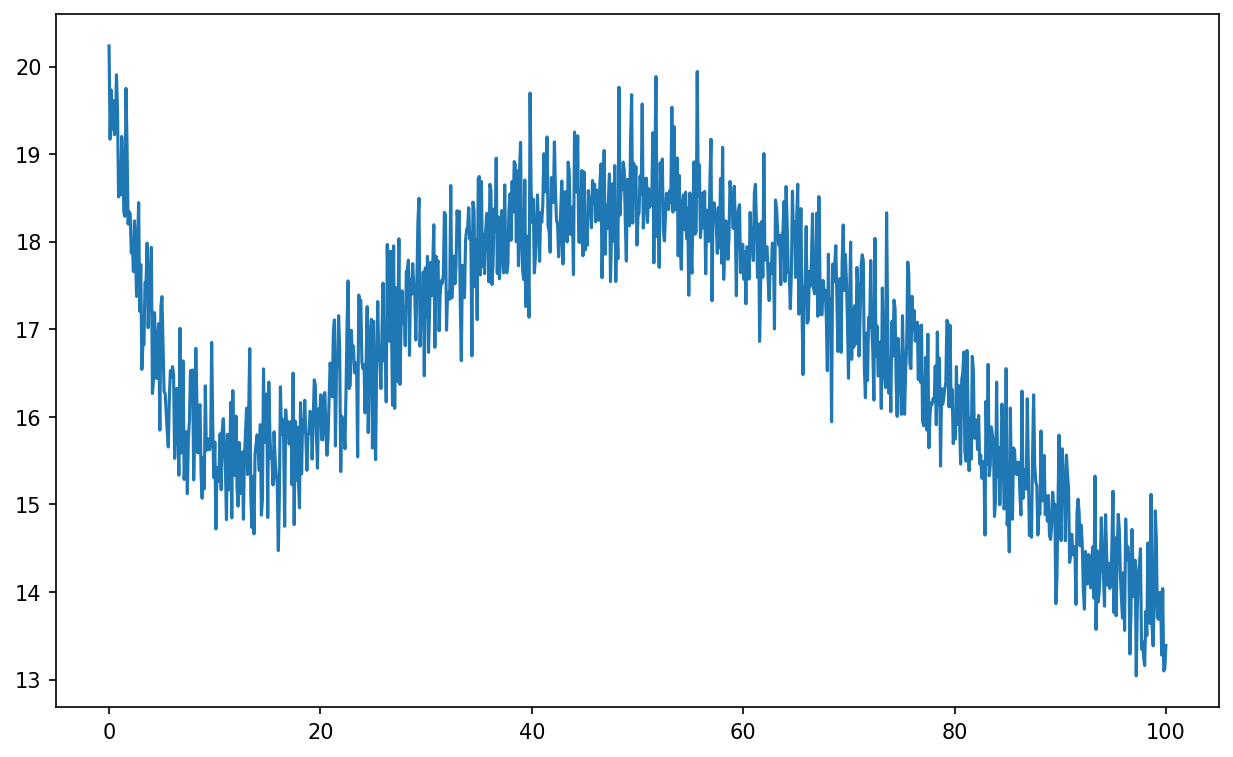

In [4]:
plt.figure(figsize=(10,6),dpi=150)
plt.plot(df['x'], df['y'])
plt.show()

In [5]:
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=True)

print(df_train.shape)
print(df_test.shape)

(800, 2)
(200, 2)


In [6]:
df_train = df_train.sort_values(by=['x'])
df_test  = df_test.sort_values(by=['x'])

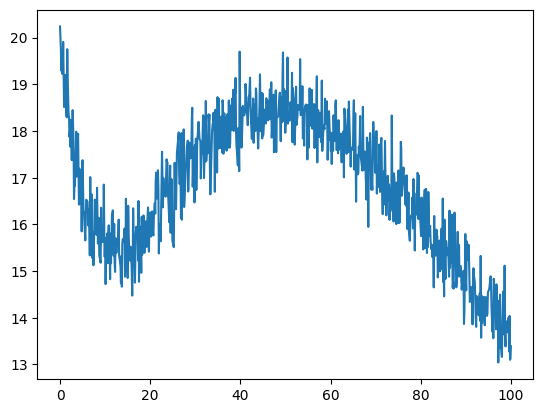

In [7]:
plt.plot(df_train['x'], df_train['y'])
plt.show()

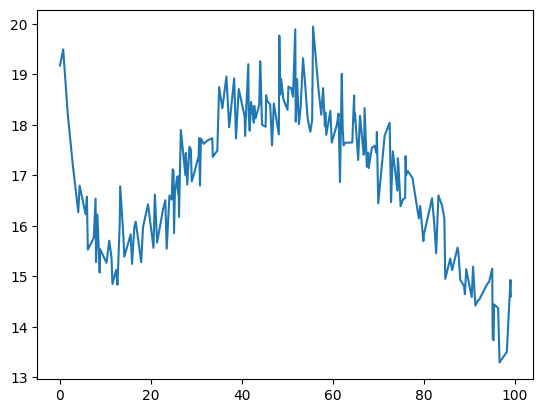

In [8]:
plt.plot(df_test['x'], df_test['y'])
plt.show()

In [9]:
scaler = RobustScaler()

scaler.fit(df_train)

df_train = scaler.transform(df_train)
df_test  = scaler.transform(df_test)

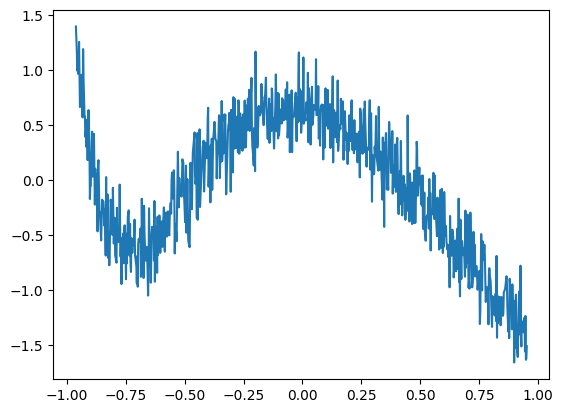

In [10]:
plt.plot(df_train[:,0], df_train[:,1])
plt.show()

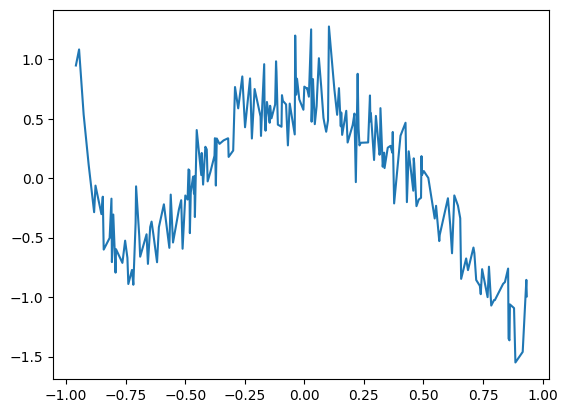

In [11]:
plt.plot(df_test[:,0], df_test[:,1])
plt.show()

In [12]:
class NoisyData(Dataset):
    def __init__(self, df):
        x = df[:,0]
        y = df[:,1]
        self.x = torch.tensor(x, dtype=torch.float32).reshape((-1,1))
        self.y = torch.tensor(y, dtype=torch.float32).reshape((-1,1))

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [13]:
ds_train = NoisyData(df_train)
ds_test  = NoisyData(df_test)

In [14]:
ds_train[:10]

(tensor([[-0.9608],
         [-0.9569],
         [-0.9550],
         [-0.9531],
         [-0.9512],
         [-0.9493],
         [-0.9474],
         [-0.9435],
         [-0.9416],
         [-0.9397]]),
 tensor([[1.4001],
         [1.1868],
         [0.9971],
         [1.1351],
         [0.9692],
         [0.9821],
         [1.2597],
         [0.6673],
         [0.8319],
         [0.6777]]))

## Bayes Neural Network

In [15]:
class VBLinear(nn.Module):
    __constants__ = ['in_features', 'out_features']
    in_features: int
    out_features: int
    weight: torch.Tensor

    def __init__(self, in_features, out_features):
        super(VBLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.resample = True
        self.bias = nn.Parameter(torch.Tensor(out_features))
        self.mu_w = nn.Parameter(torch.Tensor(out_features, in_features))
        self.logsig2_w = nn.Parameter(torch.Tensor(out_features, in_features))
        self.random = torch.randn_like(self.mu_w)
        self.reset_parameters()

    def forward(self, x):
        if self.resample:
            self.random = torch.randn_like(self.mu_w)
        s2_w = self.logsig2_w.exp()
        weight = self.mu_w + s2_w.sqrt() * self.random
        return F.linear(x, weight, self.bias)

    def reset_parameters(self):
        std = 1. / np.sqrt(self.mu_w.size(1))
        self.mu_w.data.uniform_(-std, std)
        self.logsig2_w.data.zero_().normal_(-9, 0.001)
        self.bias.data.zero_()

    def KL(self, loguniform=False):
        return 0.5 * (self.mu_w.pow(2) + self.logsig2_w.exp() - self.logsig2_w - 1).sum()

In [16]:
print(VBLinear(2,1)(torch.randn(3,2)))
print(VBLinear(2,1)(torch.randn(3,2)))

tensor([[ 0.0721],
        [-0.2195],
        [-0.1165]], grad_fn=<AddmmBackward0>)
tensor([[-0.1059],
        [ 0.0593],
        [ 0.2132]], grad_fn=<AddmmBackward0>)


In [17]:
class BNN(L.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.lr          = hparams['learning_rate']
        self.batch       = hparams['batch_size']
        self.train_size  = hparams['train_size']
        self.hidden_size = hparams['hidden_size']
        self.num_layers  = hparams['num_layers']
        self.epochs      = hparams['epochs']

        self.save_hyperparameters()

        vbnet = []
        net = []

        # First Layer
        vb = VBLinear(1, self.hidden_size)
        vbnet.append(vb)
        net.extend([
            vb,
            nn.ReLU(inplace=True),
        ])
        for _ in range(self.num_layers):
            vb = VBLinear(self.hidden_size, self.hidden_size)
            vbnet.append(vb)
            net.extend([
                vb,
                nn.ReLU(inplace=True),
            ])

        vb = VBLinear(self.hidden_size, 2)
        vbnet.append(vb)
        net.append(vb)
        self.vbnet = vbnet
        self.net = nn.Sequential(*net)
    
    def forward(self, x):
        return self.net(x)

    def KL(self):
        kl = 0
        for vb in self.vbnet:
            kl += vb.KL()
        return kl / self.train_size

    def neg_log_gauss(self, outputs, targets):
        mu = outputs[:,0]
        logsigma2 = outputs[:,1]
        out = torch.pow(mu - targets, 2) / (2 * logsigma2.exp()) + 0.5 * logsigma2
        return torch.mean(out)
        
    def training_step(self, batch, batch_idx):
        x, y = batch
        pred = self(x)
        nl   = self.neg_log_gauss(pred, y.reshape(-1))
        kl   = self.KL()
        loss = nl + kl
        self.log('train_kl', kl)
        self.log('train_nl', nl)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        pred = self(x)
        nl   = self.neg_log_gauss(pred, y.reshape(-1))
        kl   = self.KL()
        loss = nl + kl
        self.log('val_kl', kl)
        self.log('val_nl', nl)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": OneCycleLR(
                    optimizer,
                    max_lr = self.lr,
                    epochs = self.epochs,
                    steps_per_epoch = len(ds_train) // self.batch + 1,
                ),
                "interval": "step",
                "monitor": "val_loss",
                "strict": True,
            }
        }

In [18]:
hparams = {
    'learning_rate': 1e-3,
    'batch_size': 32,
    'train_size': len(ds_train),
    'epochs': 2000,
    'hidden_size': 16,
    'num_layers': 4
}

In [19]:
dl_train = DataLoader(ds_train, batch_size=hparams['batch_size'], shuffle=True)
dl_test  = DataLoader(ds_test, batch_size=hparams['batch_size'], shuffle=False)

In [20]:
model = BNN(hparams)
model

BNN(
  (net): Sequential(
    (0): VBLinear()
    (1): ReLU(inplace=True)
    (2): VBLinear()
    (3): ReLU(inplace=True)
    (4): VBLinear()
    (5): ReLU(inplace=True)
    (6): VBLinear()
    (7): ReLU(inplace=True)
    (8): VBLinear()
    (9): ReLU(inplace=True)
    (10): VBLinear()
  )
)

In [21]:
summary(model, input_size=(hparams['batch_size'], 1))

Layer (type:depth-idx)                   Output Shape              Param #
BNN                                      [32, 2]                   --
├─Sequential: 1-1                        [32, 2]                   --
│    └─VBLinear: 2-1                     [32, 16]                  48
│    └─ReLU: 2-2                         [32, 16]                  --
│    └─VBLinear: 2-3                     [32, 16]                  528
│    └─ReLU: 2-4                         [32, 16]                  --
│    └─VBLinear: 2-5                     [32, 16]                  528
│    └─ReLU: 2-6                         [32, 16]                  --
│    └─VBLinear: 2-7                     [32, 16]                  528
│    └─ReLU: 2-8                         [32, 16]                  --
│    └─VBLinear: 2-9                     [32, 16]                  528
│    └─ReLU: 2-10                        [32, 16]                  --
│    └─VBLinear: 2-11                    [32, 2]                   66
Total param

In [22]:
wandb_logger = WandbLogger(
    project="Noisy_Regression"  
)

wandb: Currently logged in as: axect. Use `wandb login --relogin` to force relogin


In [23]:
trainer = Trainer(
    logger = wandb_logger,
    max_epochs = hparams['epochs'],
    devices=[0],
    accelerator='auto',
    enable_progress_bar=False,
    callbacks=[
        ModelCheckpoint(monitor='val_loss', mode='min', save_top_k=3),
        LearningRateMonitor(logging_interval="epoch"),
    ]
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [24]:
trainer.fit(model, dl_train, dl_test)

You are using a CUDA device ('NVIDIA GeForce RTX 3050 4GB Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 2.2 K 
------------------------------------
2.2 K     Trainable params
0         Non-trainable params
2.2 K     Total params
0.009     Total estimated model params size (MB)
/home/xteca/Documents/Project/Machine_Learning/Noisy_Regression/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_work

In [25]:
import os, re

In [26]:
ckpt_dir = f"./Noisy_Regression/{wandb.run.id}/checkpoints/"
regex    = re.compile('epoch=(\d+)-step=(\d+).ckpt')
candis   = []
for root, _, files in os.walk(ckpt_dir):
    for file in files:
        if regex.match(file):
            candis.append(root + file)

In [27]:
candis

['./Noisy_Regression/xghf51ze/checkpoints/epoch=1712-step=42825.ckpt',
 './Noisy_Regression/xghf51ze/checkpoints/epoch=1868-step=46725.ckpt',
 './Noisy_Regression/xghf51ze/checkpoints/epoch=1893-step=47350.ckpt']

In [28]:
best_model = BNN.load_from_checkpoint(candis[-1])
best_model

BNN(
  (net): Sequential(
    (0): VBLinear()
    (1): ReLU(inplace=True)
    (2): VBLinear()
    (3): ReLU(inplace=True)
    (4): VBLinear()
    (5): ReLU(inplace=True)
    (6): VBLinear()
    (7): ReLU(inplace=True)
    (8): VBLinear()
    (9): ReLU(inplace=True)
    (10): VBLinear()
  )
)

In [29]:
wandb.finish()

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,▁▁▂▂▃▄▅▆▆▇▇██████▇▇▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁
train_kl,████▇▇▇▆▆▅▅▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,██▇▇▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_nl,█▆▄▃▂▄▂▃▂▂▂▂▂▂▃▃▂▂▂▂▂▂▂▂▃▂▃▁▂▂▁▂▂▃▂▂▂▂▂▂
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_kl,████▇▇▇▆▆▅▅▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▇▆▆▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_nl,█▆▃▃▂▁▁▁▂▁▂▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▂▁▁
epoch,1999
lr-Adam,1e-05


In [30]:
def decoder(model, dl):
    x_input = []
    y_input = []
    y_output = []
    s_output = []

    for x, y in dl:
        x_input.extend(x.flatten())
        y_input.extend(y.flatten())

        x = x.to(model.device)
        y = y.to(model.device)

        y_hat = model(x)[:,0:1]
        s_hat = model(x)[:,1:2]
        y_output.extend(y_hat.detach().cpu().numpy().flatten())
        s_output.extend(s_hat.exp().sqrt().detach().cpu().numpy().flatten())

    return x_input, y_input, y_output, s_output

In [31]:
x_input, y_input, y_output, s_output = decoder(model, dl_train)

X_data = np.column_stack([x_input, y_input])
X_data = X_data[X_data[:,0].argsort()]

X_hat = np.column_stack([x_input, y_output, s_output])
X_hat = X_hat[X_hat[:,0].argsort()]

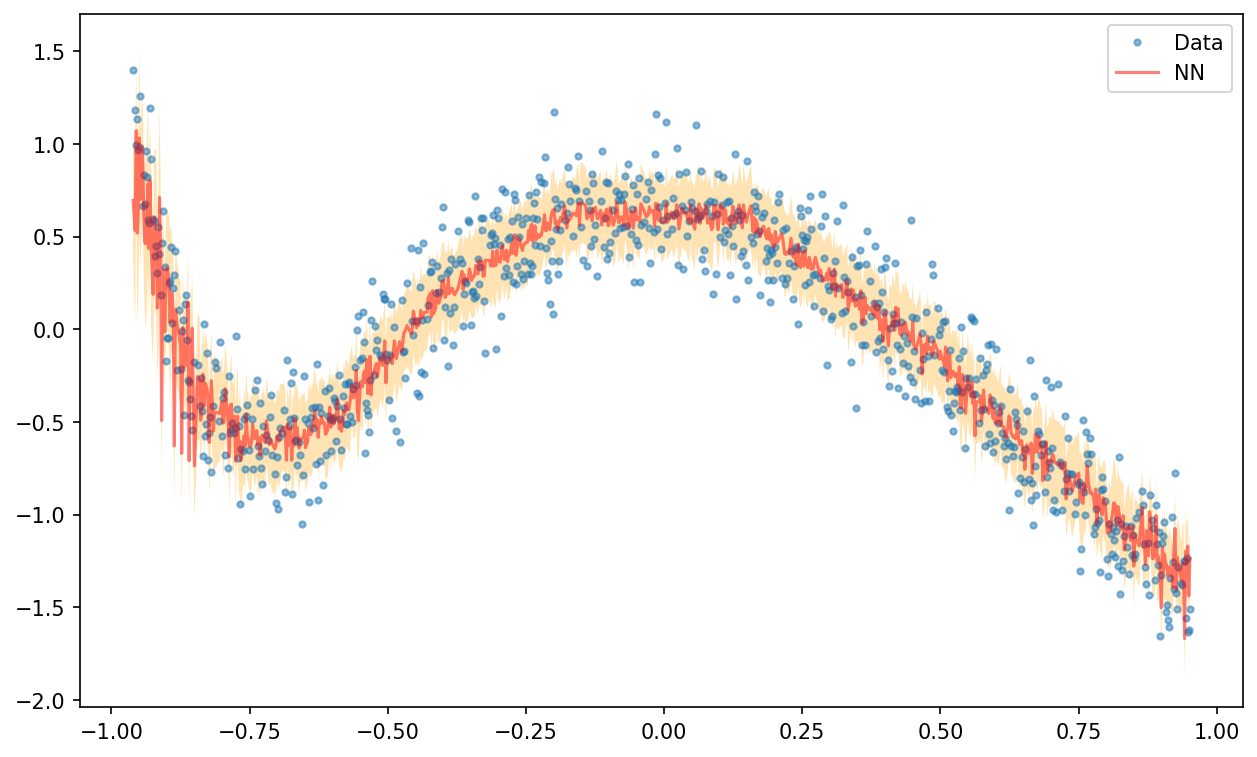

In [32]:
plt.figure(figsize=(10,6), dpi=150)
plt.plot(X_data[:,0], X_data[:,1], '.', label='Data', alpha=0.5)
plt.plot(X_hat[:,0], X_hat[:,1], 'r-', label='NN', alpha=0.5)
plt.fill_between(X_hat[:,0], X_hat[:,1]-X_hat[:,2], X_hat[:,1]+X_hat[:,2], alpha=0.3, facecolor='orange')
plt.legend()
plt.show()

In [33]:
x_input, y_input, y_output, s_output = decoder(model, dl_test)

X_data = np.column_stack([x_input, y_input])
X_data = X_data[X_data[:,0].argsort()]

X_hat = np.column_stack([x_input, y_output, s_output])
X_hat = X_hat[X_hat[:,0].argsort()]

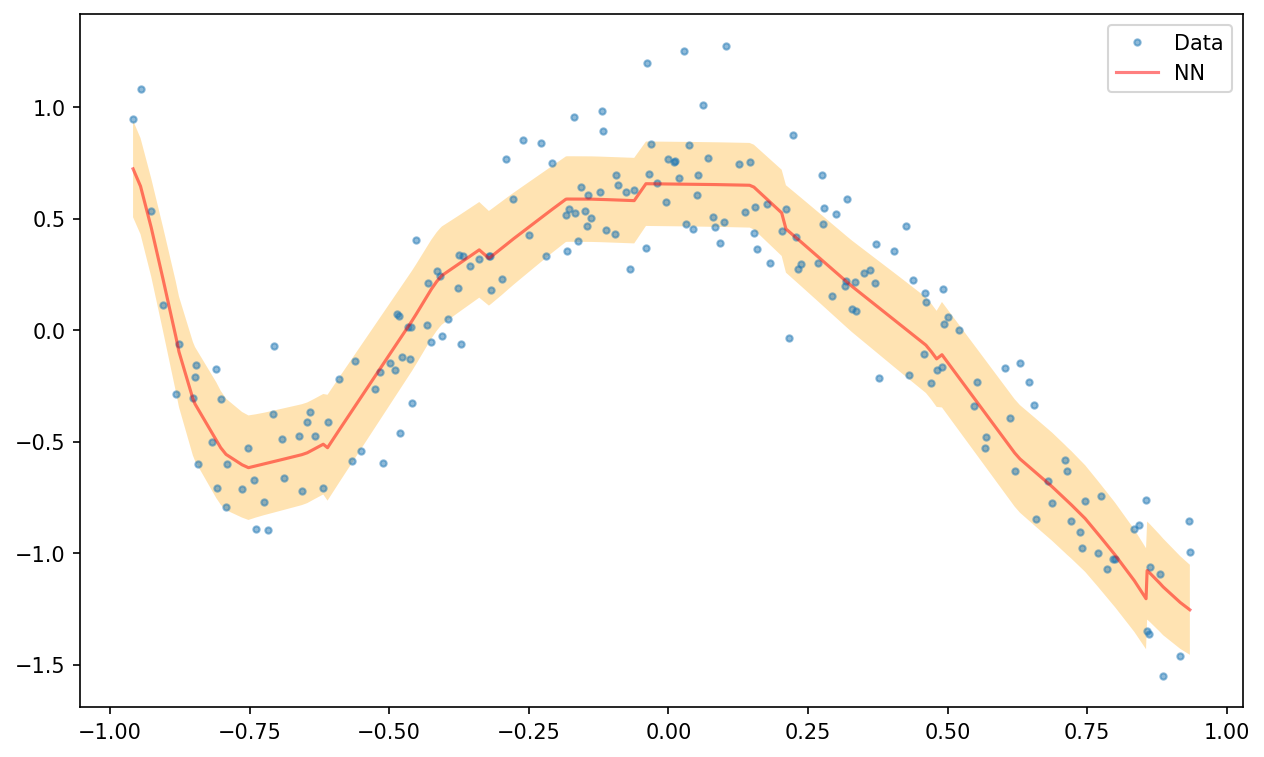

In [34]:
plt.figure(figsize=(10,6), dpi=150)
plt.plot(X_data[:,0], X_data[:,1], '.', label='Data', alpha=0.5)
plt.plot(X_hat[:,0], X_hat[:,1], 'r-', label='NN', alpha=0.5)
plt.fill_between(X_hat[:,0], X_hat[:,1]-X_hat[:,2], X_hat[:,1]+X_hat[:,2], alpha=0.3, facecolor='orange')
plt.legend()
plt.show()